# TRAVEL PATTERNS ON THE BEATIFUL HORIZON

## Preamble

This script performs a preliminary descriptive analysis of Belo Horizonte's mobility data, as presented by the OD household survey. Specifically, it presents:
- The modal division by income range
- The hourly distribution of trips (by mode)
- The main centralities of the territory

In order to do so, it is organized as follows:
- First, the functions to perform data wrangling and further manipulations are defined. Along with those in charge of plotting.
- Second, in the PROCESSING section, there's a space for parameter definition, for some supervised processing and, then, unsupervised data processing.
- Lastly, reports, graphs and plots. This last section begins with a couple user defined parameters for plotting purposes

Disclaimer:
- Wheres there's been an attempt to make the script and general as posible, it was heavily taylored for the problem at hand and it is clearly embedded in the context of the development of a Thesis. That is, sometimes I erred on the side of realiability in detriment of sheer efficiency.
- On occasion, some computations took excessively and unnecessarily long. That happened because I used H3 resolution for compatibility purposes, i.e., for compatibility with scripts in group A. That can be adjusted for in the future, but as those computations took place only once it seemed unnecessary to do so for the time being.

In [1]:
import h3
import os
import pathlib
import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from h3census.assemble import get_hexagons_with_census_data
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter
from time import perf_counter
from pandas.api.types import CategoricalDtype
from geobr import read_metro_area, read_municipality

%matplotlib inline
%config InlineBackend.figure_format='retina'

## INNER WORKINGS

### Getting Mobility Data

In [2]:
def get_od(path, metadata=None, sep=';', encoding='utf-8', decimal=','):
    data = pd.read_csv(path,
                       sep=sep,
                       encoding=encoding,
                       usecols=usecols,
                       parse_dates=datetime_cols,
                       decimal=decimal,
                      )
    
    data.rename(columns=old_with_new_names, inplace=True)
    
    
    return data


### Main Spatial Data Wrangling

In [3]:
def get_traffic_zones(path_to_zonal_data, col_with_zones,
                      data_epsg, output_epsg=31983):
    # gpd.read_file did not accept PureWindowsPath, that's 
    # why it was turned into a string.
    #
    # Shapefile's CRS was neither in the data not it was clear:
    # EPSG:4674 (GCS SIRGAS 2000) is my best guess
    if path_to_zonal_data.suffix == '.zip':
        path_to_zonal_data = ('zip://'
                              + path_to_traffic_zones.as_posix())
    
    geometries = gpd.read_file(str(path_to_zonal_data),
                               crs=f'EPSG:{data_epsg}',
                               geometry='geometry',
                              )
    geometries.to_crs(epsg=output_epsg, inplace=True)
    
    geometries.rename(columns={col_with_zones: 'traffic_zone'},
                      inplace=True,
                     )
    
    # TO DO: unhardcode this and allow for better handling of string labels
    geometries = geometries.astype({'traffic_zone': int})
    geometries = geometries.astype({'traffic_zone': str})
    
    geometries.set_index('traffic_zone', inplace=True)
    
    
    return geometries


#### Slicing the Study Area

In [4]:
def slice_study_area(tesselation, borders,
                     centrality_indices):
    """Mainly for plotting purposes. Extracts a portion of the study
    area for closer looks on the centrality heatmap. This is important
    for cases such as Belo Horizonte's Metro Area: the core municipality
    towers above all others, which leads to its whole area to be shown
    uniformly. Plotting it on its own reveals internal differentiation.
    
    Parameters
    ----------
    tesselation : GeoDataFrame
        geometries taht make up study area
    borders : GeoDataFrame
        dataframe containing contours of the slice
    centrality_indices : DataFrame
        Centrality factors for each spatial unit of the study area.
        Spatial units must be compatible with those of tesselation
        
    Returns
    -------
        slice_of_centrality_data : DataFrame
    """
    gdf = tesselation.copy()
    gdf['centres'] = gdf.geometry.map(lambda x: x.centroid)
    gdf.set_geometry('centres', inplace=True)
    
    geometries_within_slice = gpd.sjoin(gdf,
                                        borders,
                                        op='within',)
    
    mask = centrality_indices.index.isin(geometries_within_slice.index)

    slice_of_centrality_data = centrality_indices.loc[mask,:].copy()
    
    
    return slice_of_centrality_data


### The Centrality Index

The first part of this item is responsible for computing the factors that together make up the centrality index, which is calculated in the later half.

In [5]:
def _summarize_OD_flows(trip_data, disaggregation_categories):
    """Gets trips by OD pair while keeping them disaggregated
    by origin, destination, and ALSO the attrinutes in
    disaggregation_categories.
    """
    groupby = disaggregation_categories.copy()
    groupby.extend(['area_origin', 'area_destination'])
    
    # pd.DataFrame.groupby() with categorical variables may lead to excessive 
    # memory consuption (refer e.g. to link below this cell). The following
    # is a possible workaround.
    categorical_columns = trip_data.loc[:, trip_data.dtypes=='category'].columns
    if not categorical_columns.empty:
        dtype_changer = {col: 'str' for col in categorical_columns}
        trip_data = trip_data.astype(dtype_changer)
    
    trips_by_OD_pair = trip_data.pivot_table('expansion_factor',
                                             index=groupby,
                                             aggfunc='sum',
                                            )
    
    
    return trips_by_OD_pair.reset_index()


def _compute_travel_density(OD_data):
    """Computes the proportion of trips that are attracted by each zone
    as a percentage of all trips internal to the study area.
    """
    total_trips = OD_data.expansion_factor.sum()
    trips_by_destination_zone = OD_data.pivot_table('expansion_factor',
                                                    index='area_destination',
                                                    aggfunc='sum',
                                                   )
    densities = trips_by_destination_zone / total_trips
    
    densities.sort_index(inplace=True)
    densities.name = 'D'

    
    return densities


def _entropy_formula(trip_data, K):
    """Implements Shannon's entropy formula, while handling for cases
    where there is the log calculation of 0.
    """
    trips_by_category = trip_data.expansion_factor.to_numpy()
    P = trips_by_category / np.sum(trips_by_category)
    
    with np.errstate(divide='ignore'):
        log_P = np.log(P)     
    log_P[np.isneginf(log_P)] = 0
    # When P approaches zero, the entropy approaches zero, but to that effect
    # in a computational environment, log(0) must be handled lest it returns
    # an error.
    # 
    # See link below this cell for further details on
    # the handling of the above division error

    entropy = -K * np.sum(P*log_P)
    
    
    return entropy


def _compute_entropy(OD_data, attribute):
    values = OD_data[attribute].unique()
    K = 1/np.log(len(values)) # Coefficient of the entropy formula below
    
    grouped_data = OD_data.groupby(['area_destination', attribute],
                                   as_index=False,
                                   ).sum()
    
    # TO DO: use grouoby + apply?
    entropies = {}
    for zone,group in grouped_data.groupby('area_destination'):
        entropies[zone] = _entropy_formula(group, K)
        
    entropies = pd.DataFrame.from_dict(entropies,
                                       orient='index',
                                       columns=[f'E_{attribute}'],
                                      )
    entropies.sort_index(inplace=True)

    
    return entropies


def _compute_factors(OD_data, entropy_of):
    
    factors = [_compute_travel_density(OD_data)]
    for attribute in entropy_of:
        factors.append(_compute_entropy(OD_data, attribute))
    
    factors = pd.concat(factors, axis=1)    
    factors = factors.apply(lambda x: x/x.max())
    
    
    return factors

        
def _get_centrality_factors(OD_data, disaggregation_categories,
                            entropy_of, modes=None, mode_col=None):
    
    flows = _summarize_OD_flows(OD_data, disaggregation_categories)
    
    centrality_factors = _compute_factors(flows, entropy_of)
    column_keys = 'all'
    
    if modes:
        column_keys = [column_keys]
        column_keys.extend(modes)
        
        # Since factors for 'all' (modes) have already been computed,
        # we skip the index 0 at column_keys
        centrality_factors = [centrality_factors]
        for key in column_keys[1:]:
            OD_slice = flows.loc[flows[mode_col]==key]
            OD_slice.name = OD_data.index.name
            centrality_factors.append(_compute_factors(OD_slice, entropy_of))
    
        centrality_factors = pd.concat(centrality_factors,
                                       axis=1,
                                       keys=column_keys,
                                      )
    
    else:
        new_column_names = [
            (column_keys, col) for col in centrality_factors.columns
                           ]
        new_column_names = pd.MultiIndex.from_tuples(new_column_names)
        centrality_factors.set_axis(new_column_names,
                                    axis='columns',
                                    inplace=True,
                                   )
    
    
    return centrality_factors


def _assign_factors_to_zone_geometries(factors_by_zone, traffic_zones):
    # pandas warns against mergin MultiIndex with Single Index, which
    # will happen in a later step. I then wrote the following 
    # workaround, which may not be the best, but will do, for now.
    #
    # Maybe the warning is not a big deal, but I'll avoid it until I'm sure
    column_tuples = [('shapes', 'geometry')]
    MultiIndex = pd.MultiIndex.from_tuples(column_tuples)
    zone_gdf = traffic_zones.set_axis(MultiIndex, axis='columns')
    
    
    factors_by_zone = zone_gdf.merge(factors_by_zone,
                                     how='inner',
                                     left_index=True,
                                     right_index=True,
                                     )
    
    
    return factors_by_zone


def _assign_factors_to_hex(factors_by_zone, hexagons):
    # Spatial join used to behave awkwardly when it involved multiindex
    # so, to be safe, I walked around them.
    #
    # TO DO: check hithub and whatnot to see if the awkwardness persists
    original_columns = factors_by_zone.columns
    temp_col_idx = list(range(len(original_columns)))
    factors_by_zone.set_axis(temp_col_idx, axis='columns', inplace=True)
    factors_by_zone.set_geometry(0, inplace=True)
    
    hex_gdf = hexagons.reset_index()
    hex_gdf['centroid'] = hex_gdf.geometry.map(lambda x: x.centroid)
    hex_gdf.set_geometry('centroid', inplace=True)
    
    factors_by_hex = gpd.sjoin(hex_gdf,
                               factors_by_zone,
                               how='inner',
                               op='within',
                              )
    factors_by_hex.set_index(hexagons.index.name, inplace=True)
    factors_by_hex.drop(columns=['index_right','centroid'], inplace=True)

    # 0-indexed column of factors_by_zone prior to sjoin was ('shapes' 'geometry'),
    # which corresponds to traffic zone geometries. After sjoin, we convenintly 
    # have a new GeoDataFrame whose 0-indexed column is also a geometry columns,
    # but it contains the appropriate H3 hex geometry. Therefore, we can simply
    # use original_columns again.
    factors_by_hex.set_axis(original_columns, axis='columns', inplace=True)
    factors_by_hex.set_geometry(('shapes', 'geometry'), inplace=True)
    
    
    return factors_by_hex
    
    
def get_centrality_factors_by_hex(OD_data, traffic_zones, hexagons, 
                                  disaggregation_categories, entropy_of,
                                  modes=None, mode_col=None):
    """Computes the factors that constitute the centrality index:
    First, computes travel density per each travel destination zone
    in the study area. Then, it looks into the flows directed to each
    cell and computes the associated Shannon entropy associated with them.

    Optionally, it disaggregates the above factors by transport mode.
    
    Density and diversity (as reflected by entropy) are two quantities
    with different dimensions and physical meanings. To integrate them
    into a single function, as it will be done later, we first convert
    them from absolute values to a ranked ordering. Simply put, each of
    the three factors computed herein are scaled so that the highest
    value for each is 1.
    
    Then, computed factors are assigned to the appropriate H3 hexagons.
    
    Parameters
    ----------
    OD_data : DataFrame
        Flow data between origin-destination pairs
    traffic_zones : GeoDataFrame
    hexagons : GeoDataFrame
    disaggregation_categories : list
        Trip grouping will keep flow data disaggregated by OD pair
        and ALSO by the attrinutes in this parameter.
    entropy_of : str, list
        Name of colums containing attributes to calculate the entropy of.
        E.g., if one wants to get the entropy of trip purposes associated
        with the travel flows, the parameter should receive the name of
        the column in OD_data with those purposes.
        This parameter MUST be a subset of 'disaggregation_categories'
    modes : list
        Name of the modes to get centrality factors of
    mode_col : str
        Name of colum in OD_data containing the travel modes
        
    Returns
    -------
    centrality_factors : DataFrame
        DataFrame with MultiIndexed columns, in which the highest level 
        identifies each mode, and the lowest level concerns the respective
        centrality factors.
    """
    factors_by_zone = _get_centrality_factors(OD_data,
                                              disaggregation_categories,
                                              entropy_of,
                                              modes,
                                              mode_col,)
    
    factors_by_zone = _assign_factors_to_zone_geometries(factors_by_zone,
                                                         traffic_zones,)
    
    factors_by_zone = gpd.GeoDataFrame(factors_by_zone,
                                       geometry=('shapes', 'geometry'),
                                       crs=f'EPSG:{traffic_zones.crs.to_epsg()}',)
    
    mode_keys = factors_by_zone.columns.get_level_values(0).unique()
    mode_keys = mode_keys.drop('shapes')
    
    factors_by_hex = _assign_factors_to_hex(factors_by_zone,
                                            hexagons,)
    
    factors_by_hex.fillna(0, inplace=True)
    
    
    return mode_keys, factors_by_hex


On the log calculation: https://stackoverflow.com/a/21753388/15994934

On memory usage during groupby with categoricals: https://github.com/pandas-dev/pandas/issues/17594

In [6]:
def _get_neighborhood(hexagon_label, number_of_rings):
    """Gets the labels of all hexagons contained in an n number of
    rings. Rings are centered in the hexagon labeled 'hexagon_label'.
    Result is returned as a set.
    """
    rings = h3.hex_range_distances(hexagon_label, number_of_rings)
    
    neighborhood = set()
    for ring in rings:
        neighborhood = neighborhood.union(ring)
    
    
    return neighborhood


def _get_neighborhood_portion_inside_study_area(labels, neighborhood):
    """H3 hexagons constitute a hexagonal grid that spans the globe.
    Therefore, py-h3's standard implementation to return the neighbors
    of a given hexagon is insensitive to the study area boundaries.
    
    This function takes all potential neighbors of an hexagon and
    discards those outside the studied territory.
    """
    labels = set(labels)        
    neighborhood = neighborhood.intersection(labels)
    
    
    return list(neighborhood)
    
    
def _compute_neighborhood_operations(data, key, number_of_rings):
    """This function computes centrality by convolution-based smoothing,
    as described in Zhong et al. (2017)
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame where each column contains one of the factors that
        make up the centrality index
    key : iterable
        List-like containing names of the modes used within
        get_centrality_factors()
    number_of_rings : int
        Number of rings used ford spatial smoothing
    """
    centrality_indices = {}
    labels = data.index
    number_of_labels = len(labels)
    
    tic = perf_counter()
    centrality_indices = {}
    print(f'{key.upper()} --------------------------------------------------')
    for i,label in enumerate(labels):
        
        neighborhood = _get_neighborhood(label, number_of_rings)
        neighborhood = _get_neighborhood_portion_inside_study_area(labels,
                                                                   neighborhood,
                                                                  )
        
        if neighborhood:
            
            neighborhood = data.loc[neighborhood,:].to_numpy()
            
            # TO DO: is it worth writing a function for these
            # numpy manipulations?
            a = neighborhood[:,0]
            a = np.reshape(a, (1,-1))
            
            b = neighborhood[:,1]
            b = np.reshape(b, (1,-1))
            
            # Note how this array is of a different dimension than those above
            c = neighborhood[:,2]
            c = np.reshape(c, (-1,1))
            
            centrality_indices[label] = np.sum((a * b) @ c)
            # TO DO: is there a better way to get the integer resulting from
            # the above matrix operation than using np.sum()?
        
        if i%(number_of_labels//4)==0:
            percentage = i/number_of_labels*100
            toc = perf_counter()
            print(
                f'{round(percentage):.2f}% or {i}/{number_of_labels} of '\
                f'hexagons were processed in {(toc-tic)/60:.1f} min' \
                 )
    
    centralities = pd.DataFrame.from_dict(centrality_indices,
                                          orient='index',
                                          columns=[key],
                                         )
    
    
    return centralities


def compute_centrality_index(factors, keys,
                             neighborhood_size):
    # TO DO: allow for variation according to time of day
    
    centralities = []
    for key in keys:
        slice_of_hexagons = factors.loc[:, key]
        centralities.append(
            _compute_neighborhood_operations(slice_of_hexagons,
                                             key,
                                             neighborhood_size
                                            )
                           )
        
    centralities = pd.concat(centralities, axis=1)
    
    
    return centralities


### Plotting Data

#### Modal share by income interval

In [7]:
def _get_data_shares_by_y_label(group, quant, x_labels, y_labels):
    trip_shares = (
        group[quant]
        / group[quant].sum()
        *100
                  )
    #trip_shares = round(trip_shares)
    col_names = group[y_labels]
    output = pd.Series(trip_shares.values, index=list(col_names))
    return output


def _get_data_share_by_labels(df, quant, x_labels, y_labels):
    grouped_data = df.pivot_table(quant,
                                  index=[x_labels, y_labels],
                                  aggfunc='sum',
                                  ).reset_index()
    grouped_data.sort_values([x_labels, y_labels], inplace=True)

    grouped_data = grouped_data.groupby(x_labels)
    grouped_data = grouped_data.apply(_get_data_shares_by_y_label,
                                      quant,
                                      x_labels,
                                      y_labels,
                                     )
    
    return grouped_data


def _wrangle_data_for_hor_bars(df, quant, x_labels, y_labels):
    shares_by_categories = _get_data_share_by_labels(df, quant, x_labels, y_labels)
    
    #top_labels = list(shares_by_categories.columns)
    #y_labels = list(shares_by_categories.index)
    #x_data = shares_by_categories.values
    
    # TO DO: delete following two blocks if chart is to be in english
    new_names = {'active': 'Ativo',
                 'public': 'Coletivo',
                 'private': 'Individual',}
    shares_by_categories.rename(columns=new_names, inplace=True)
    
    new_name = {'undisclosed': 'não declarou'}
    shares_by_categories.rename(index=new_name, inplace=True)
    
    shares_by_categories = shares_by_categories.to_dict('split')
    category_names = shares_by_categories['columns']
    shares = {
        category: shares 
        for category,shares 
        in zip(shares_by_categories['index'], shares_by_categories['data'])
             }
    
    
    return category_names, shares


def plot_hor_bar_chart_with_categories(df, quant, x_labels, y_labels):
    """Stacked bar charts that can be used to visualize
    discrete distributions.
    
    Parameters
    ----------
    df : DataFrame
    quant : str
        Column in df that contains the quantity to be visualized
    x_labels, y_labels: str
        Column names to disaggregate x by.
    
    Returns
    -------
    fig, ax
    
    TO DO: quant does not really seem a good name. Think of another.
    """
    
    category_names, shares = _wrangle_data_for_hor_bars(df, quant, x_labels, y_labels)
    
    labels = list(shares.keys())
    data = np.array(list(shares.values()))
    data_cum = data.cumsum(axis=1)
    #category_colors = plt.get_cmap('RdYlGn')(
    #    np.linspace(0.15, 0.85, data.shape[1]))
    #
    # TO DO: "unhardcode" colors
    category_colors = ['#82A775',
                       '#3B727C',
                       '#B05F66',]

    fig, ax = plt.subplots(figsize=(9.2, 4), dpi=300)
    ax.invert_yaxis()
    #ax.xaxis.set_visible(False) This makes the ax x label invisible as well
    ax.get_xaxis().set_ticks([])
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
        xcenters = starts + widths / 2

        #r, g, b, _ = color
        text_color = 'white' #if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(1, 0.95),
              loc='lower right', fontsize='small', frameon=False)
    
    ax.set_facecolor('#D1BE9D')
    ax.tick_params(axis='y', which='both', left=False)
    for each in ["top", "bottom", "left", "right"]:
        ax.spines[each].set_visible(False)
    
    ax.set_xlabel('%')
    
    fig.set_facecolor('#D1BE9D')
    #fig.suptitle('Divisão Modal por Paridade de Poder de Compra', ha='center', fontsize=16, color='#64513B')

    return fig, ax

#### Trip hourly distribution

In [8]:
def _plot_params(df, ax, hue=None):
    date_form = DateFormatter("%H")
    
    sns.lineplot(ax=ax,
                 data=df,
                 x='departure_time',
                 y='expansion_factor',
                 hue=hue,)
    xlim = [df.departure_time.min(), df.departure_time.max()]
    ax.set(xlim=xlim)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    

def _get_total_trips_by_mode(df):
    trips_by_mode = []
    for key,group in trips.groupby('mode_type'):
        df = group.resample('H',
                            on='departure_time',
                            label='left',)
        df = df[['expansion_factor']].sum()
        df.rename(columns={'expansion_factor': key},
                  inplace=True,)
        trips_by_mode.append(df)
    
    df = pd.concat(trips_by_mode,
                   axis=1,
                  ).reset_index()
    
    df = df.melt(id_vars=df.columns[0],
                 value_vars=df.columns[1:],
                 var_name='mode',
                 value_name='expansion_factor',)
    
    
    return df
    

def plot_trip_hourly_distribution(data):    
    sns.set_theme()
    
    fig,ax = plt.subplots(ncols=2,
                          figsize=(30, 5),
                          sharey=True,)
    ax1,ax2 = ax
    
    df = trips.resample('H',
                        on='departure_time',
                        label='left',)
    df = df[['expansion_factor']].sum()
    df.sort_index(inplace=True)
    
    _plot_params(df.reset_index(), ax1)

    df = _get_total_trips_by_mode(data)
    
    _plot_params(df, ax2, hue='mode')
    

#### Map Plotters

In [9]:
def _get_outer_centrality_ranking(df):
    """This cuts centrality data into
    bins based on their order of magnitude.
    """
    cuts = pd.cut(df,
                  bins=[0, 1e-3, 1e-2, 1e-1, 1],
                  labels=['negligible', 'low', 'medium', 'high'],)
    
    # Bins are open at the left edge, thus zeroes have
    # not been assigned to any category and hence are set to none 
    cuts = cuts.cat.add_categories('none').fillna('none')
    cuts = cuts.cat.reorder_categories(['none',
                                        'negligible',
                                        'low',
                                        'medium',
                                        'high',])
    
    
    return cuts


def _get_inner_cuts(bin_, group, color_mappings, n):
    # It makes no sense to find gradients of 'none' bin,
    # as all of it is exactly zero.
    if bin_ == 'none':
        subcuts = pd.cut(group,
                         bins=1,
                         labels=[0],)
    else:
        colors = color_mappings[3*n : 3*n+3]

        subcuts = pd.cut(group,
                         bins=3,
                         labels=colors,
                         )
        
        
    return subcuts


def _get_inner_centrality_ranking(df, outer_rank, mode):
    """Once places are ranked based on the magnitude of
    their centrality indices, groups are subdivided internally
    into 3 groups.
    
    If there's 
    """
    number_of_categories = len(outer_rank
                               .cat
                               .categories)
    color_mappings = np.linspace(0,
                                 1,
                                 3*number_of_categories) 
    
    inner_ranking = {}
    for n,(bin_,group) in enumerate(df.groupby(outer_rank)[mode]):
        try:
            inner_ranking[bin_] = _get_inner_cuts(bin_,
                                                  group,
                                                  color_mappings,
                                                  n,)
        except:
            pass
        
        
    return inner_ranking
    
    
def _rank_centralities(df):
    """Rank hexagons based on their centrality indices,
    based on the rationale above this cell.
    """
    full_ranking = {}
    for mode in df.columns:
        outer_ranking = _get_outer_centrality_ranking(df[mode])

        inner_ranking = _get_inner_centrality_ranking(df,
                                                      outer_ranking,
                                                      mode,)

        full_ranking[mode] = inner_ranking
        
        
    return full_ranking
        

In [10]:
def _draw_modal_rankings(geometries, full_ranking, mode, ax, cmap):    
    rank_by_hex_label = (pd.DataFrame
                         .from_dict(full_ranking[mode])
                         .apply(lambda x: x.sum(), axis=1))
    rank_by_hex_label.name = mode
    
    ranked_hexes = pd.merge(geometries,
                            rank_by_hex_label,
                            left_index=True,
                            right_index=True,)
    
    ranked_hexes.plot(ax=ax,
                      column=mode,
                      cmap=cmap,
                      linewidth=0,)
    ax.set_title(mode)
    ax.axis('off')

In [11]:
def draw_centrality_map(gdf, df, cmap):
    full_ranking = _rank_centralities(df)
    modes = list(full_ranking.keys())
    
    fig,axes = plt.subplots(ncols=len(modes),
                            sharey=True,
                            dpi=300,)
                            
    for mode,ax in zip(modes, axes):
        _draw_modal_rankings(gdf.geometry,
                             full_ranking,
                             mode,
                             ax,
                             cmap)
        

## PROCESSING

### Main Parameters

#### Filepaths

In [12]:
out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'B'

db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

In [13]:
census_folder = db_folder / 'Census/2010 Universo/'
path_to_census = census_folder / '2010_aggregates_by_enumeration_area.csv'

In [14]:
BH_trip_data_folder = (db_folder
                       / 'beaga'
                       / 'origin_destination_survey'
                       / '2012')

path_to_trip_metadata = BH_trip_data_folder / 'internal_trips_RMBH_vars_to_use.csv'
path_to_trip_data = BH_trip_data_folder / 'internal_trips_RMBH.csv'
path_to_traffic_zones = BH_trip_data_folder / 'malha_areas_homogeneas.zip'

#### Parameters relted to geocomputations

In [15]:
state = 31 # MG ID as int
code_muni = 3106200 # Belo Horizonte ID as str
                    # TO DO: allow ibgeID as int as well

# The following is the first year (in geobr) when BH Metro Area
# appears partitioned innto a core and an outer ring, which makes
# it (more) compatible with the OD data,while being temporally close
metro_area_year = 2015 

name_metro = 'RM Belo Horizonte'
subdivision = 'RM Belo Horizonte' # Keeps core, discards outer ring

reference_epsg = 31983 # SIRGAS 2000 / UTM zone 23S

hexagon_size = 8 # close in are to that of the median traffic zone
neighborhood_size = 3 # For the centrality calulation

H3 Resolutions: https://h3geo.org/docs/core-library/restable

#### Parameters for Trip Data Wrangling

In [16]:
# Traffic zone CRS was not clear: EPSG:4674 (GCS SIRGAS 2000) is my best guess
trip_data_epsg = 4674

# It will compute the entropy of these attributes
entropy_of = ['purpose_at_destination',
              'area_origin',]

col_with_zone_labels='AH2011'
col_with_mode_labels = 'mode_type'

# Modes to disaggregate centrality index by. The keys are the names in the 
# original data, the items, the simplification I want. This dictionary will be
# used with df.replace() a few cells below.
modes = {
    'Não motorizado': 'active',
    'coletivo': 'public',
    'individual': 'private',
    'Outros': 'others',
        }

# See _totalize_OD_flows() for more info on this parameter
disaggregation_categories = ['purpose_at_destination',
                             'mode_type',
                             'income',
                             'education_level',]

#### Parameters for Zooming in BH

These are meant for the map plotting functions.

In [17]:
BH_borders = read_municipality(code_muni=code_muni,
                               year=metro_area_year,)

BH_borders.to_crs(epsg=reference_epsg, inplace=True)

column_labels = list(modes.values())[:-1] # See 1.3.1
column_labels.append('all')

#### General Purpose

In [26]:
# Centrality computation can be costly: just under 1 hour
# for H3 resolution 9. Hence, in the event of rerunning the code,
# one might want to skip it this computation.

# If compute_centrality is set to False, the code assumes that
# a previous run of the computation is saved elsewhere. This copy
# should be a text file with the same structure as otputted by
# compute_centrality().
compute_centrality = True

### Supervised (Pre)Processing

Operations that need some supervision and, ocasionally, some manual tuning

In [27]:
# NOTE: Zones are read in as float. 
# Conversion to str is hardcoded within this function
traffic_zones = get_traffic_zones(path_to_zonal_data=path_to_traffic_zones,
                                  col_with_zones=col_with_zone_labels,
                                  data_epsg=trip_data_epsg,
                                  output_epsg=reference_epsg,)

In [28]:
def get_hexagon_edge_length(gdf):
    median_area = np.median(gdf.area)
    edge_length = np.sqrt(median_area * 2 / (3 * np.sqrt(3)))
    
    print(f'Hex edge should be of approximately {edge_length / 1e3:.2f} km') 



get_hexagon_edge_length(traffic_zones)

Hex edge should be of approximately 0.59 km


That is close to hex 8, with side of 0.46 km. That one is to be used.

In [29]:
metadata = get_metadata(path=path_to_trip_metadata)

trips = get_od(path=path_to_trip_data,
               metadata=metadata,)

In [30]:
# This selects trips more closely associated with economic activity.
trips = trips.loc[~trips.purpose_at_destination.isin(['Residência', 'Escala'])]

# Zones from OD are read as int
#
# TO DO: make this more robust to different dtypes
trips = trips.astype({
    'area_origin': str,
    'area_destination': str,
                    })


# Incomes converted to ranges that correspond to Oct 2012 values for PPP, 
# rounded up from 359,30 (source: Ipeadata)
#
# NOTE: the OD survey was conducted from August to November 2012
income_intervals = {
    'O entrevistado não quis informar a renda': 'undisclosed',
    'Sem renda': '0',
    'Até 1 SM  ': '0 - 360',
    'Mais de 1 até 2 SM ': '360 - 720',
    'Mais de 2 até 3 SM  ': '720 - 1,080',
    'Mais de 3 até 5 SM  ': '1,080 - 1800',
    'Mais de 5 até 10 SM ': '1,800 - 3,600',
    'Mais de 10 até 15 SM  ': '3,600 - 5,400',
    'Mais de 15 até 20 SM  ': '5,400 - 7,200',
    'Mais de 20 SM ': '7,200 +',
                    }
income_order = CategoricalDtype(list(income_intervals.values()), ordered=True)

# There's no real mode hierarchy, but this results in
# better data presentation/visualization, later
mode_order = CategoricalDtype(list(modes.values()), ordered=True)

trips.replace({'income': income_intervals, 'mode_type': modes}, inplace=True)
trips = trips.astype({'income': income_order, 'mode_type': mode_order})

In [31]:
def get_cities_in_metro_area(name_metro):
    """This is hardcoded for BH's case and
    will NOT work properly for most cases.
    """
    metro_footprint = read_metro_area(year=2015)
    
    mask = ((metro_footprint.name_metro==name_metro)
            & (metro_footprint.subdivision==name_metro))
    metro_footprint = metro_footprint.loc[mask]

    BH_metro_cities = metro_footprint.code_muni.unique()
    BH_metro_cities = BH_metro_cities.astype(int)
    BH_metro_cities = BH_metro_cities.astype(str)
    
    
    return BH_metro_cities


usecols = {
    'v002': 'pop',
    # Average income of all those who are 10 years
    # or older and earn wages of some sort
    'v011': 'income',
         }
cities = get_cities_in_metro_area(name_metro)


hexagons = get_hexagons_with_census_data(state,
                                         cities,
                                         hexagon_size,
                                         usecols,
                                         area_weighted_vars=['pop'],
                                         query_data=False,
                                         save_query=False,
                                         path=path_to_census,
                                         pop_col='pop',
                                         pop_weighted_vars=['income'],
                                         output_epsg=31983,)

Sanity check:
 11893 H3 labels, with resolution 8,  after dropping 0 duplicates


### Unsupervised Processing

As much as possible, whatever serves as input to this section should either be defined in section 1.3 or it should be hardcoded. If a solution comes up to "unhardcode" something, such something should go to 1.3.

In [32]:
mode_keys, centrality_factors_by_hex = get_centrality_factors_by_hex(
    
    trips,
    traffic_zones,
    hexagons[['geometry']],
    disaggregation_categories,
    entropy_of,
    list(modes.values())[:-1], # Drops Others, as they are pratically inexistent
    col_with_mode_labels,
                                                                     
                                                                    )

In [35]:
path_to_centralities = (out_folder
                        / f'RMBH_OD2012_centrality_by_hex{hexagon_size}_label.csv')

if compute_centrality:
    raw_centralities = compute_centrality_index(
        
        factors=centrality_factors_by_hex,
        keys=mode_keys,
        neighborhood_size=neighborhood_size,
        
    )

    raw_centralities.to_csv(path_to_centralities)

else:
    raw_centralities = pd.read_csv(path_to_centralities,
                                   index_col=0,)
    

ALL --------------------------------------------------
0.00% or 0/10663 of hexagons were processed in 0.0 min
25.00% or 2665/10663 of hexagons were processed in 0.1 min
50.00% or 5330/10663 of hexagons were processed in 0.2 min
75.00% or 7995/10663 of hexagons were processed in 0.3 min
100.00% or 10660/10663 of hexagons were processed in 0.3 min
ACTIVE --------------------------------------------------
0.00% or 0/10663 of hexagons were processed in 0.0 min
25.00% or 2665/10663 of hexagons were processed in 0.1 min
50.00% or 5330/10663 of hexagons were processed in 0.2 min
75.00% or 7995/10663 of hexagons were processed in 0.3 min
100.00% or 10660/10663 of hexagons were processed in 0.3 min
PUBLIC --------------------------------------------------
0.00% or 0/10663 of hexagons were processed in 0.0 min
25.00% or 2665/10663 of hexagons were processed in 0.1 min
50.00% or 5330/10663 of hexagons were processed in 0.2 min
75.00% or 7995/10663 of hexagons were processed in 0.3 min
100.00% or 

## REPORTS, GRAPHS AND VISUALISATIONS

### Basic Plots and Charts

This is supervised

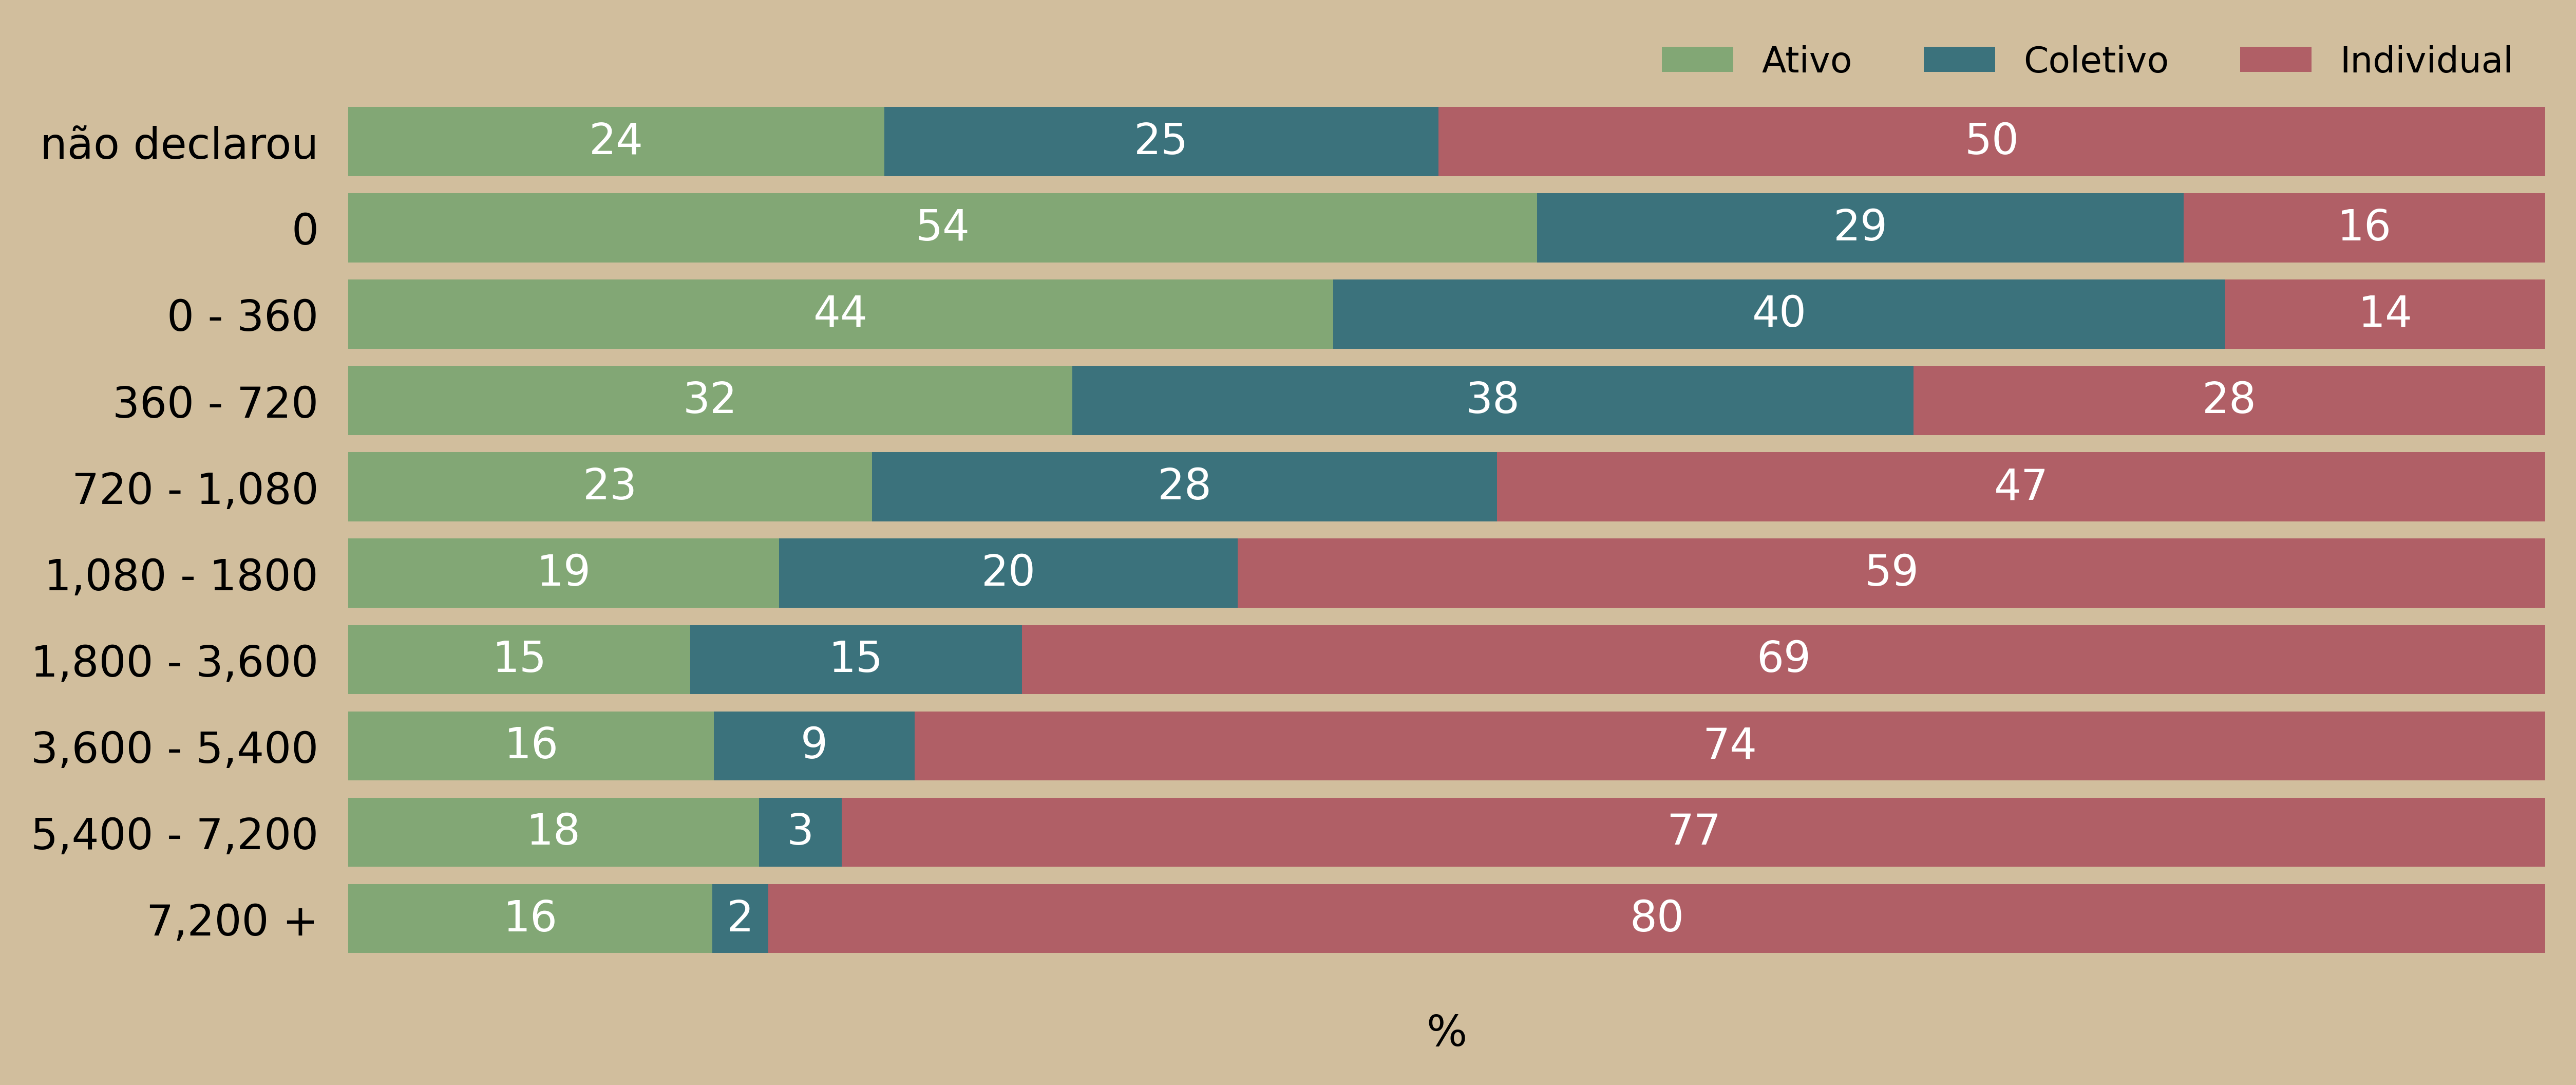

In [36]:
# This is virtually zero, thus only making the plot clumsy
drop_cat = 'others'

plot_hor_bar_chart_with_categories(df=trips.loc[trips.mode_type!=drop_cat],
                                   quant='expansion_factor',
                                   x_labels='income',
                                   y_labels='mode_type',
                                  )
plt.savefig('modal_share_BH_by_PPP.png')
plt.show()

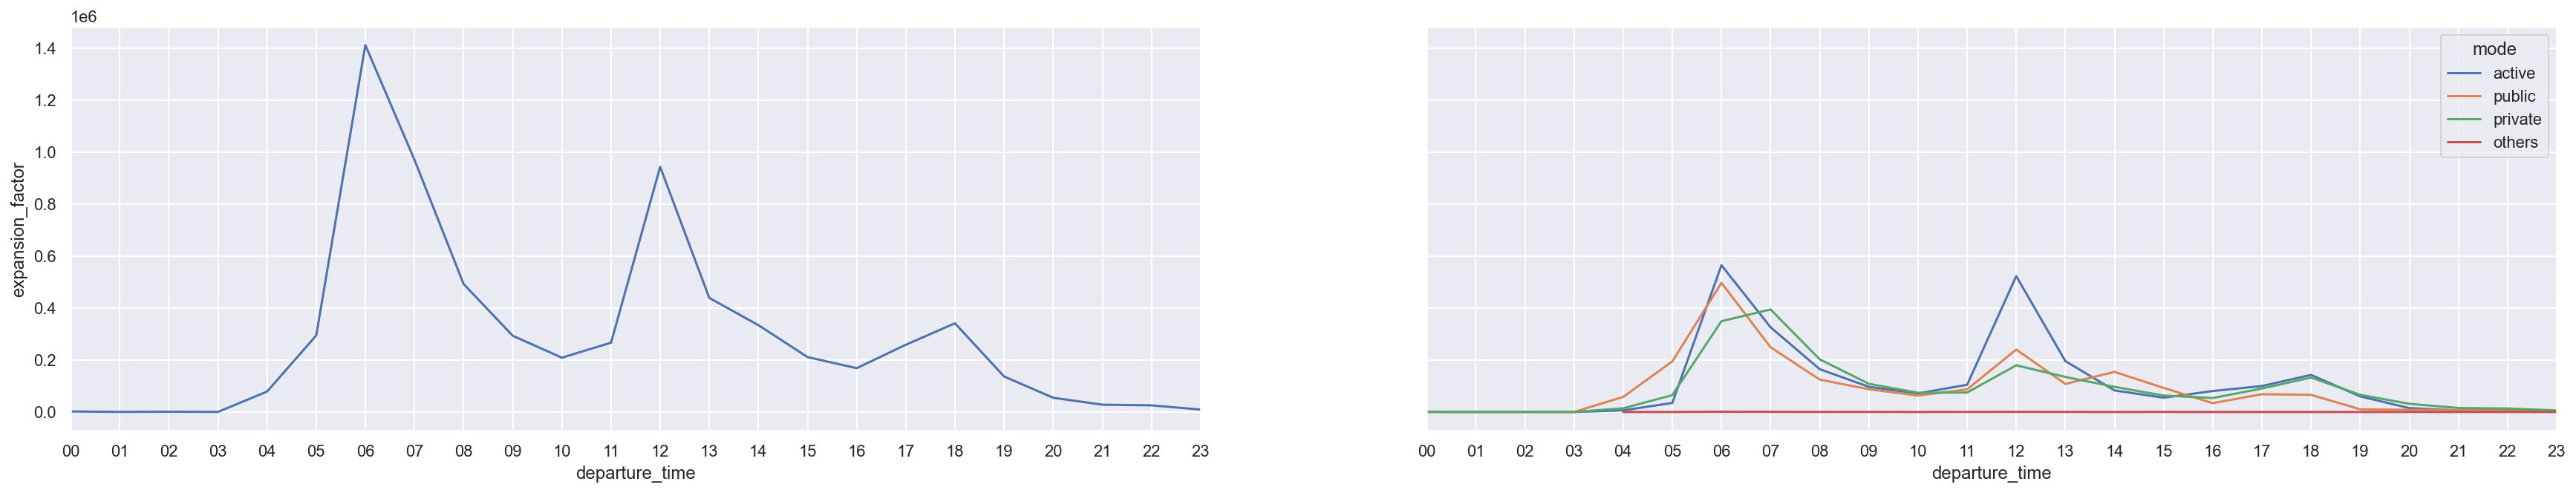

In [37]:
# Departure times has been parsed as string
# TO DO: find where and why
trips['departure_time'] = pd.to_datetime(trips.departure_time)


plot_trip_hourly_distribution(trips)

### Map Plots of Centrality Indices

We are not interested in which mode (or combination of modes)
ranks highest _per se_, but which are the main centralities for each
case. Hence, previously computed centrality indices are adjusted to
a notionally common scale. That is, the indicies for all modes, or
combination thereof, are each normalized to be in the range [0,1].

That allows for a more coherent cross comparison.

In [38]:
norm_centralities = raw_centralities.apply(lambda x: x/x.max())

norm_centralities.describe(percentiles=[.5, .75, .8, .85, .9, .95, .99])

,all,active,public,private
count,10663.000000,10663.000000,10663.000000,10663.000000
mean,0.036258,0.064201,0.019349,0.033497
std,0.097530,0.147307,0.074492,0.104117
min,0.000000,0.000000,0.000000,0.000000
50%,0.003838,0.005810,0.000780,0.002065
75%,0.021850,0.042984,0.008340,0.013128
80%,0.035157,0.071029,0.012649,0.021462
85%,0.054302,0.115386,0.020137,0.039941
90%,0.089494,0.189114,0.036414,0.073164
95%,0.188880,0.400159,0.085760,0.188172


It is clear that centrality distribution is highly skewed, which demands some workarounds for better data analysis and visualization. I chose to split the data into groups based on their order of magnitude:
- Each group will be of a different colour than the other;
- Except for active travel, all other columns in the 75th percentile have the same order of magnitude 1e-3, and I arbitrated that all values of lower magnitude will be gathered in the same group;
- Places with no centrality at all will also be part of the same group.

The above will result in 5 groups:
- Each group will be subdivided internally in 3 subgroups;
- Intra group distinction amongst areas will be based on a gradient of the group colour.

#### Centrality Map for RMBH

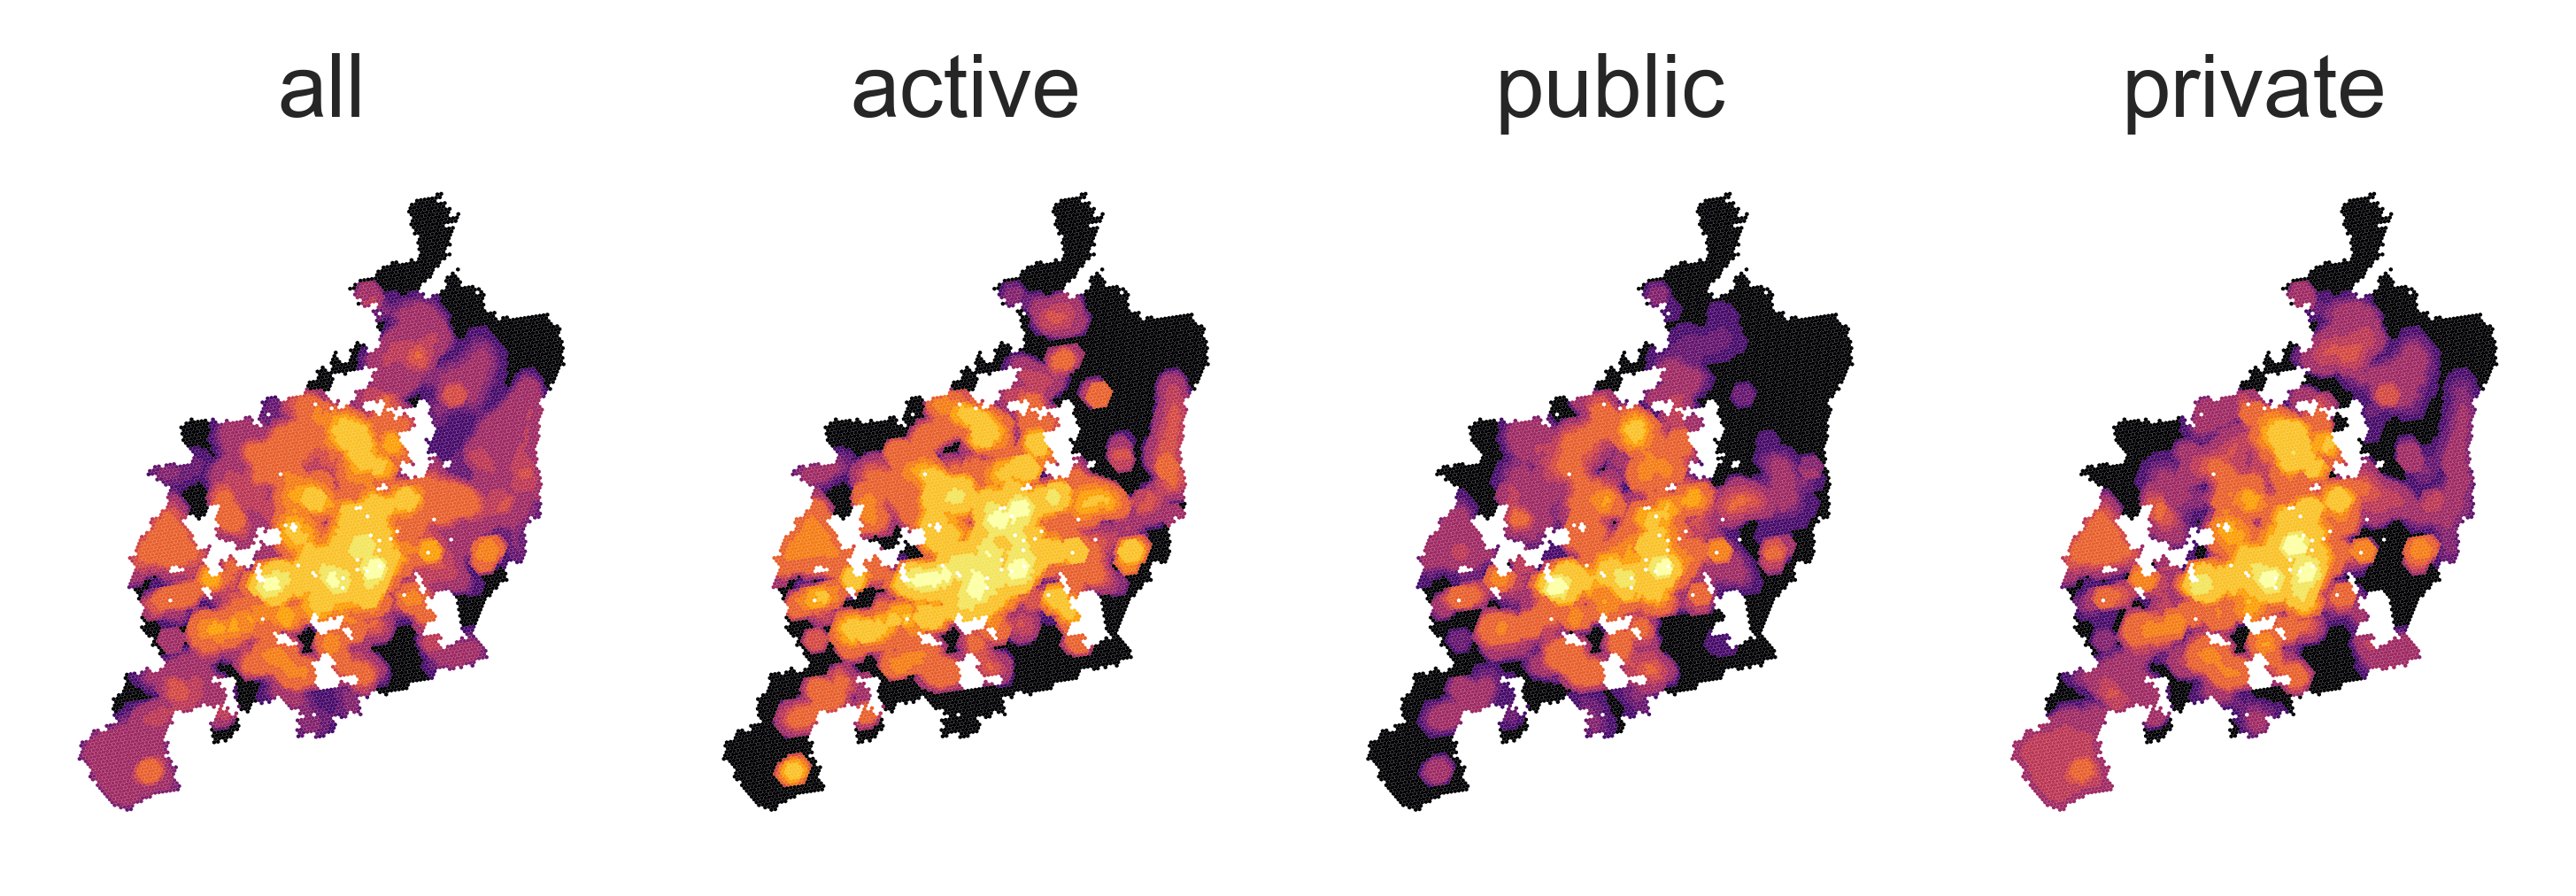

In [39]:
draw_centrality_map(hexagons,
                    norm_centralities,
                    cmap='inferno')

#### Centrality Map for BH

In [40]:
BH_raw_centralities = slice_study_area(hexagons,
                                       BH_borders,
                                       raw_centralities,)

BH_norm_centralities = BH_raw_centralities.apply(lambda x: x/x.max())

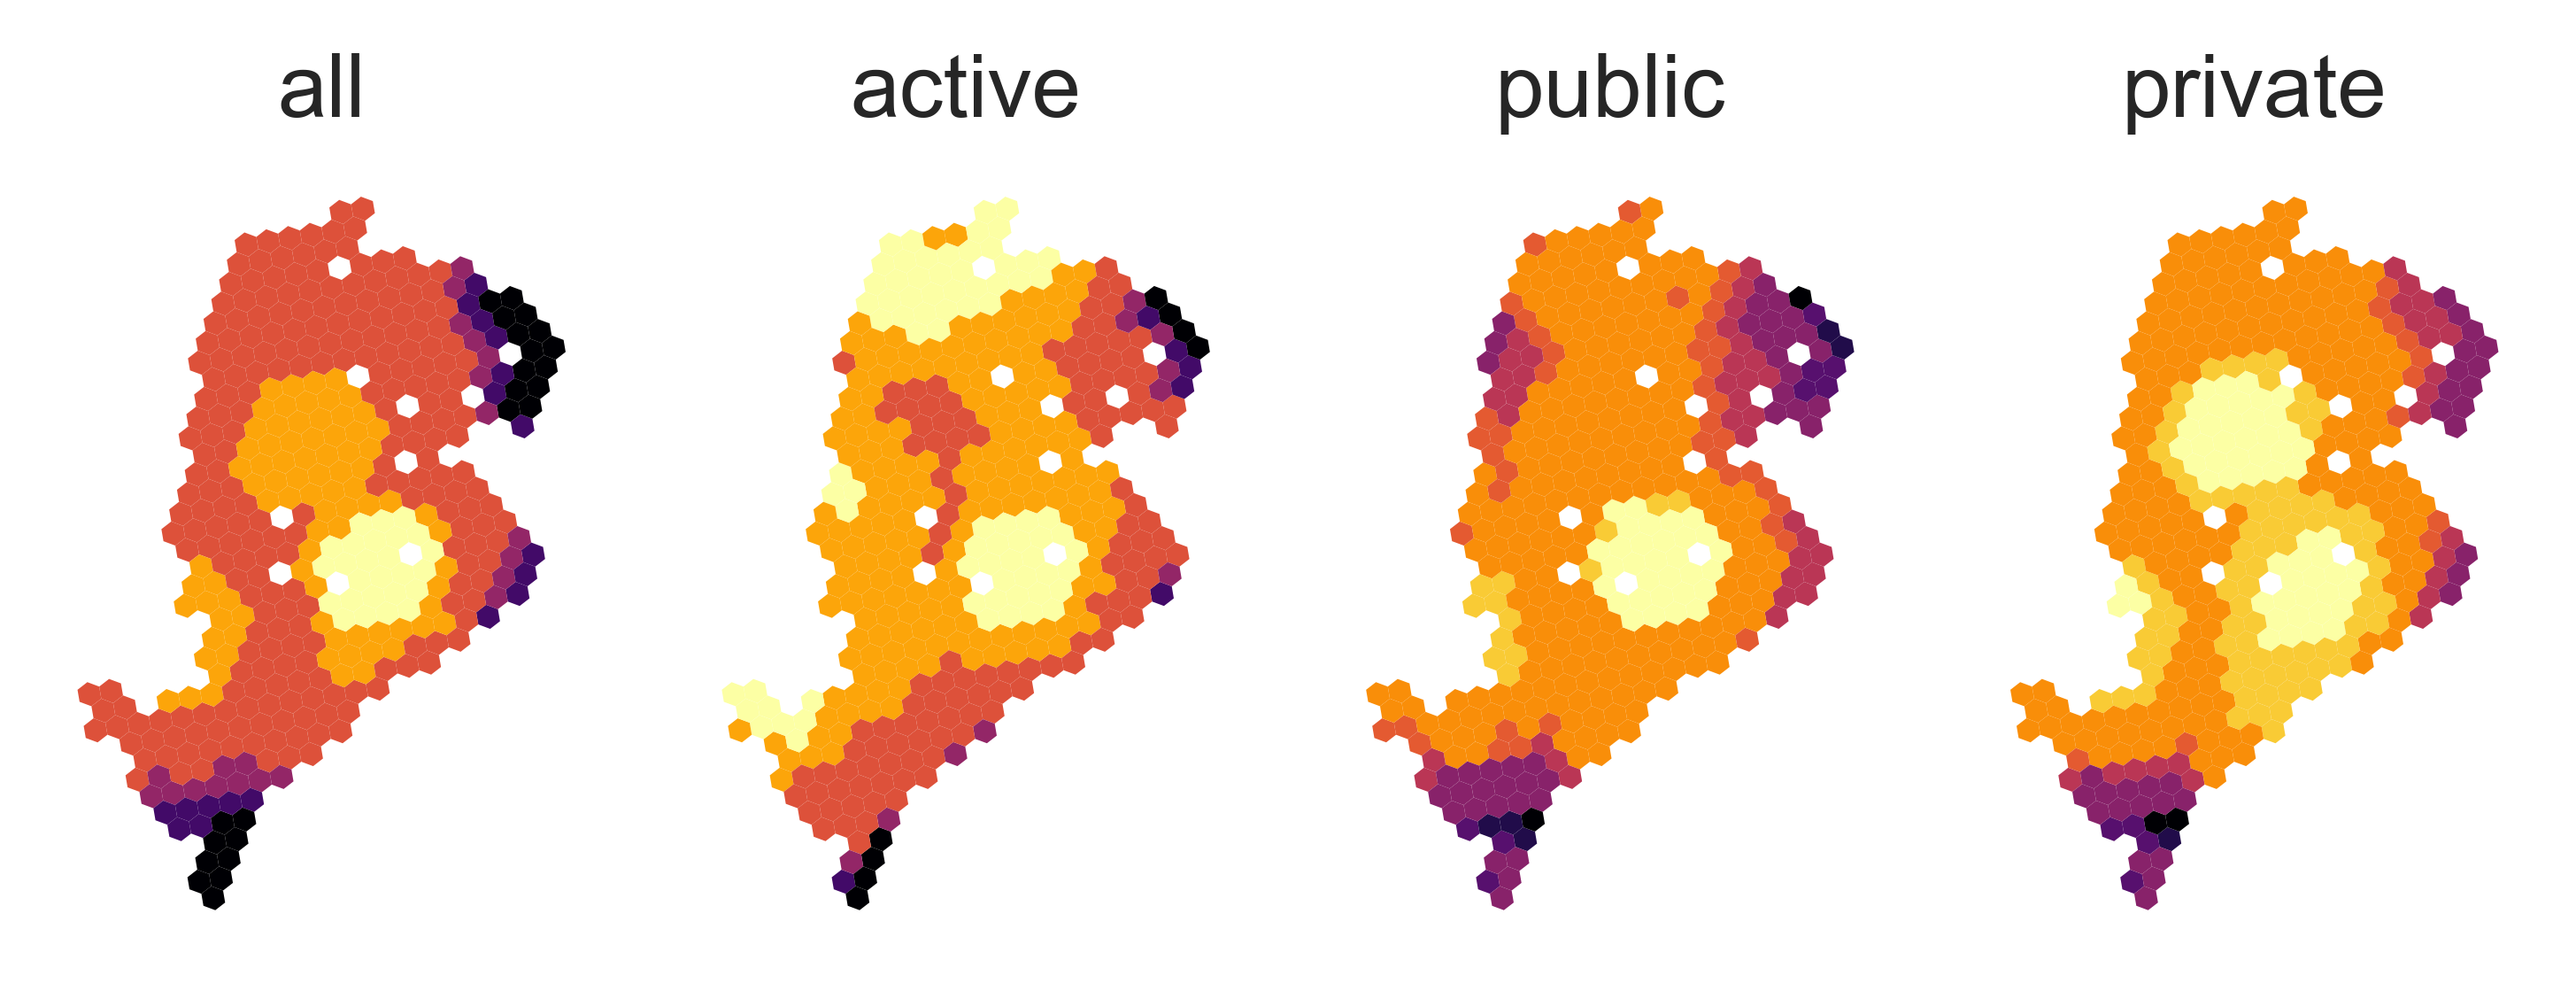

In [41]:
draw_centrality_map(hexagons,
                    BH_norm_centralities,
                    cmap='inferno')                                                                                          